
KeplerLightCurveCelerite.ipynb
==

---------------------------------

‹ KeplerLightCurve.ipynb › Copyright (C) ‹ 2017 › ‹ Anna Scaife - anna.scaife@manchester.ac.uk ›
This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

---------------------------------

[AMS - 170829] Notebook created for **TIARA Astrostatistics Summer School, Taipei, September 2017**.

This notebook runs through the Gaussian Process Modelling described in **Example 3** of https://arxiv.org/pdf/1703.09710.pdf and builds on the methodology presented in the accompanying lecture: "Can You Predict the Future..?"

It uses a number of Python libraries, which are all installable using **pip**.

This example uses the **celerite** GPM library (http://celerite.readthedocs.io) and the emcee package (http://dan.iel.fm/emcee/).

---------------------------------

In [1]:
%matplotlib inline

Import some libraries:

In [2]:
import numpy as np
import pylab as pl

Import the celerite Gaussian Process Modelling library and the george covariance kernels:

In [3]:
import celerite
from celerite import terms

Specify the datafile containing Kepler data for the object KIC 1430163:

In [4]:
filename="KIC1430163.tbl"
datafile = open(filename,'r')

Read the Kepler data from the file:

In [5]:
time=[];value=[]
while True:
    line = datafile.readline()
    if not line: break
        
    items=line.split()
    if (items[0][0]!='|'):
        time.append(float(items[1]))
        value.append(float(items[2]))
        
time=np.array(time)
value=np.array(value)

print "There are ",len(time)," data points"

There are  2721  data points


The paper says:

*We set the mean function to zero*
   
and we can see from Fig 7 that the data have also been normalised to have a maximum value of one.

So, let's also do that:

In [6]:
mean = np.mean(value)
value-=mean

norm = np.max(value)
value/=norm

And the time has been made relative to the first measurement:

In [7]:
day1 = time[0]
time-=day1

Make a plot like the one in Figure 7:

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


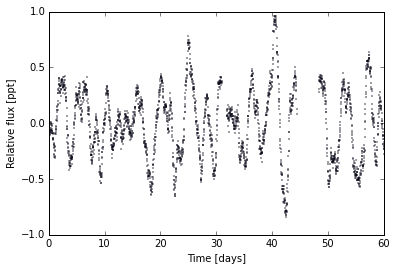

In [8]:
pl.subplot(111)
pl.scatter(time,value,s=0.2)
pl.axis([0.,60.,-1.,1.])
pl.ylabel("Relative flux [ppt]")
pl.xlabel("Time [days]")
pl.show()

In the paper there are two suggested kernels for modelling the covariance of the Kepler data (Eqs. 55 & 56). In the paper the authors fit Eq 56 - here we are going to fit **Eq. 56**.

$$
k(\tau) = \frac{B}{1+C}\exp^{-\tau/L} \left[ \cos{\left( \frac{2\pi\tau}{P} \right)} + (1+C) \right]
$$

This is the same as the *CustomTerm* described in the celerite documentation here: http://celerite.readthedocs.io/en/stable/python/kernel/ 

There is **one small difference** though - the exponent is expressed differently. This doesn't mean we need to change anything... except for our prior bounds because we're going to apply those as logarithmic bounds so we will need to put a minus sign in front of them since $\log(1/x) = -\log(x)$.

In [9]:
import autograd.numpy as np

class CustomTerm(terms.Term):
    parameter_names = ("log_a", "log_b", "log_c", "log_P")

    def get_real_coefficients(self, params):
        log_a, log_b, log_c, log_P = params
        b = np.exp(log_b)
        return (
            np.exp(log_a) * (1.0 + b) / (2.0 + b), np.exp(log_c),
        )

    def get_complex_coefficients(self, params):
        log_a, log_b, log_c, log_P = params
        b = np.exp(log_b)
        return (
            np.exp(log_a) / (2.0 + b), 0.0,
            np.exp(log_c), 2*np.pi*np.exp(-log_P),
        )

We need to pick some first guess parameters. Because we're lazy we'll just start by setting them all to 1:

In [10]:
log_a = 0.0;log_b = 0.0; log_c = 0.0; log_P = 0.0
kernel = CustomTerm(log_a, log_b, log_c, log_P)

In [11]:
gp = celerite.GP(kernel, mean=0.0)

yerr = 0.000001*np.ones(time.shape)
gp.compute(time,yerr)

print("Initial log-likelihood: {0}".format(gp.log_likelihood(value)))

Initial log-likelihood: 1691.35372503


In [12]:
t = np.arange(np.min(time),np.max(time),0.1)

# calculate expectation and variance at each point:
mu, cov = gp.predict(value, t)
std = np.sqrt(np.diag(cov))

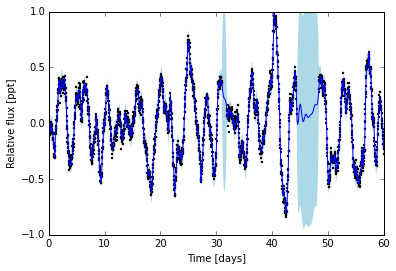

In [13]:
ax = pl.subplot(111)
pl.plot(t,mu)
ax.fill_between(t,mu-std,mu+std,facecolor='lightblue', lw=0, interpolate=True)
pl.scatter(time,value,s=2)
pl.axis([0.,60.,-1.,1.])
pl.ylabel("Relative flux [ppt]")
pl.xlabel("Time [days]")
pl.show()

The paper says:

*As with the earlier examples, we start by estimating the MAP parameters using L-BFGS-B*

So let's do that. We'll use the scipy optimiser, which requires us to define a log(likelihood) function and a function for the gradient of the log(likelihood):

In [14]:
def nll(p, y, gp):
    
    # Update the kernel parameters:
    gp.set_parameter_vector(p)
    
    #  Compute the loglikelihood:
    ll = gp.log_likelihood(y)
    
    # The scipy optimizer doesn’t play well with infinities:
    return -ll if np.isfinite(ll) else 1e25

In [15]:
def grad_nll(p, y, gp):
    
    # Update the kernel parameters:
    gp.set_parameter_vector(p)
    
    #  Compute the gradient of the loglikelihood:
    gll = gp.grad_log_likelihood(y)[1]
    
    return -gll

I'm going to set bounds on the available parameters space, i.e. our prior volume, using the ranges taken from Table 4 of https://arxiv.org/pdf/1706.05459.pdf

In [16]:
import scipy.optimize as op

# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()

# set prior ranges
# Note that these are in *logarithmic* space
bnds = ((-10.,0.),(-5.,5.),(-5.,-1.5),(-3.,5.))

# run optimization:
results = op.minimize(nll, p0, method='L-BFGS-B', jac=grad_nll, bounds=bnds, args=(value, gp))

In [17]:
# print the value of the optimised parameters:
print np.exp(results.x)
print("Final log-likelihood: {0}".format(-results.fun))

[ 0.24136748  0.00673795  0.22313016  4.24319262]
Final log-likelihood: 4421.07974678


The key parameter here is the period, which is the fourth number along. We expect this to be about 3.9 and... we're getting 4.24, so not a million miles off.

From the paper:

*This star has a published rotation period of 3.88 ± 0.58 days, measured using traditional periodogram and autocorrelation function approaches applied to Kepler data from Quarters 0–16 (Mathur et al. 2014), covering about four years.*

Let's now pass these optimised parameters to george and recompute our prediction:

In [18]:
# pass the parameters to the george kernel:
gp.set_parameter_vector(results.x)

In [19]:
t = np.arange(np.min(time),np.max(time),0.1)

# calculate expectation and variance at each point:
mu, cov = gp.predict(value, t)
std = np.sqrt(np.diag(cov))

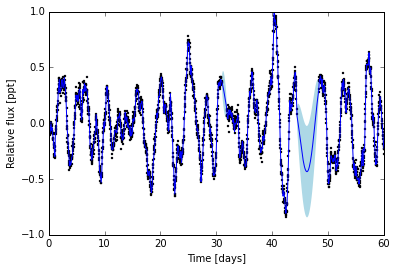

In [20]:
ax = pl.subplot(111)
pl.plot(t,mu)
ax.fill_between(t,mu-std,mu+std,facecolor='lightblue', lw=0, interpolate=True)
pl.scatter(time,value,s=2)
pl.axis([0.,60.,-1.,1.])
pl.ylabel("Relative flux [ppt]")
pl.xlabel("Time [days]")
pl.show()

---------------------------------------------------

In [60]:
import emcee

# we need to define three functions: 
# a log likelihood, a log prior & a log posterior.

First we need to define a log(likelihood). We'll use the log(likelihood) implemented in the george library, which implements:

$$
\ln L = -\frac{1}{2}(y - \mu)^{\rm T} C^{-1}(y - \mu) - \frac{1}{2}\ln |C\,| + \frac{N}{2}\ln 2\pi
$$

(see Eq. 5 in https://arxiv.org/pdf/1706.05459.pdf).

In [61]:
# set the loglikelihood:
def lnlike(p, x, y):
    
    lnB = np.log(p[0])
    lnC = p[1]
    lnL = np.log(p[2])
    lnP = np.log(p[3])
    
    p0 = np.array([lnB,lnC,lnL,lnP])
    
    # update kernel parameters:
    gp.set_parameter_vector(p0)
    
    # calculate the likelihood:
    ll = gp.log_likelihood(y)
    
    # return 
    return ll if np.isfinite(ll) else 1e25

We also need to specify our parameter priors. Here we'll just use uniform logarithmic priors. The ranges are the same as specified in **Table 3** of https://arxiv.org/pdf/1703.09710.pdf.

<img src="table3.png">

In [62]:
# set the logprior
def lnprior(p):
    
    # These ranges are taken from Table 4 
    # of https://arxiv.org/pdf/1703.09710.pdf
    
    lnB = np.log(p[0])
    lnC = p[1]
    lnL = np.log(p[2])
    lnP = np.log(p[3])
    
    # really crappy prior:
    if (-10<lnB<0.) and (-5.<lnC<5.) and (-5.<lnL<1.5) and (-3.<lnP<5.):
        return 0.0
    
    return -np.inf
    #return gp.log_prior()

We then need to combine our log likelihood and our log prior into an (unnormalised) log posterior:

In [63]:
# set the logposterior:
def lnprob(p, x, y):
    
    lp = lnprior(p)
    
    return lp + lnlike(p, x, y) if np.isfinite(lp) else -np.inf

ok, now we have our probability stuff set up we can run the MCMC. We'll start by explicitly specifying our Kepler data as our training data:

In [64]:
x_train = time
y_train = value

The paper then says:

*initialize 32 walkers by sampling from an isotropic Gaussian with a standard deviation of $10^{−5}$ centered on the MAP parameters.*

So, let's do that:

In [65]:
# put all the data into a single array:
data = (x_train,y_train)

# set your initial guess parameters
# as the output from the scipy optimiser
# remember celerite keeps these in ln() form!

# C looks like it's going to be a very small
# value - so we will sample from ln(C):
# A, lnC, L, P
p = gp.get_parameter_vector()
initial = np.array([np.exp(p[0]),p[1],np.exp(p[2]),np.exp(p[3])])
print "Initial guesses: ",initial

# set the dimension of the prior volume 
# (i.e. how many parameters do you have?)
ndim = len(initial)
print "Number of parameters: ",ndim

# The number of walkers needs to be more than twice 
# the dimension of your parameter space. 
nwalkers = 32

# perturb your inital guess parameters very slightly (10^-5)
# to get your starting values:
p0 = [np.array(initial) + 1e-5 * np.random.randn(ndim)
      for i in xrange(nwalkers)]


Initial guesses:  [ 0.11659348 -3.18813702  0.4646382   4.20700757]
Number of parameters:  4


We can then use these inputs to initiate our sampler:

In [66]:
# initalise the sampler:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

The paper says:

*We run 500 steps of burn-in, followed by 5000 steps of MCMC using emcee.*

First let's run the burn-in:

In [67]:
# run a few samples as a burn-in:
print("Running burn-in")
p0, lnp, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

Running burn-in


Now let's run the production MCMC:

In [68]:
# take the highest likelihood point from the burn-in as a
# starting point and now begin your production run:
print("Running production")
p = p0[np.argmax(lnp)]
p0 = [p + 1e-5 * np.random.randn(ndim) for i in xrange(nwalkers)]
p0, _, _ = sampler.run_mcmc(p0, 5000)

print "Finished"

Running production
Finished


In [70]:
import acor

# calculate the convergence time of our
# MCMC chains:
samples = sampler.flatchain
s2 = np.ndarray.transpose(samples)
tau, mean, sigma = acor.acor(s2)
print "Convergence time from acor: ", tau
print "Number of independent samples:", 5000.-(20.*tau)

# get rid of the samples that were taken
# before convergence:
delta = int(20*tau)
samples = sampler.flatchain[delta:,:]

Convergence time from acor:  77.1538949042
Number of independent samples: 3456.92210192


In [71]:
samples[:, 2] = np.exp(samples[:, 2])
b_mcmc, c_mcmc, l_mcmc, p_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

[ 0.11064022 -5.89915881  1.63558125  4.14598454]


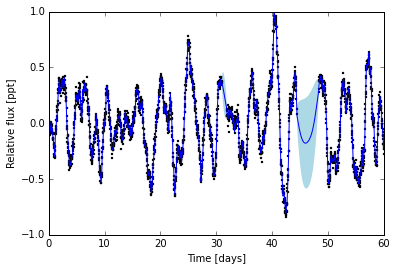

In [72]:
# specify prediction points:
t = np.arange(np.min(time),np.max(time),0.1)

# update the kernel hyper-parameters:
hp = np.array([b_mcmc[0], c_mcmc[0], l_mcmc[0], p_mcmc[0]])

lnB = np.log(p[0])
lnC = p[1]
lnL = np.log(p[2])
lnP = np.log(p[3])
    
p0 = np.array([lnB,lnC,lnL,lnP])  
gp.set_parameter_vector(p0)

    
print hp
# calculate expectation and variance at each point:
mu, cov = gp.predict(value, t)
  
ax = pl.subplot(111)
pl.plot(t,mu)
ax.fill_between(t,mu-std,mu+std,facecolor='lightblue', lw=0, interpolate=True)
pl.scatter(time,value,s=2)
pl.axis([0.,60.,-1.,1.])
pl.ylabel("Relative flux [ppt]")
pl.xlabel("Time [days]")
pl.show()

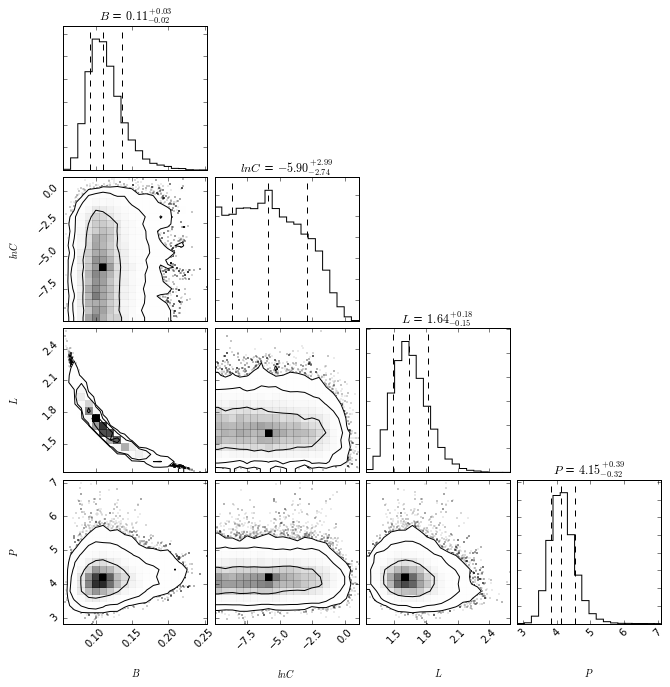

In [73]:
import corner

# Plot it.
figure = corner.corner(samples, labels=[r"$B$", r"$lnC$", r"$L$", r"$P$"],
                         quantiles=[0.16,0.5,0.84],
                         #levels=[0.39,0.86,0.99],
                         levels=[0.68,0.95,0.99],
                         title="KIC 1430163",
                         show_titles=True, title_args={"fontsize": 12})

--------------------------------------------------------------------------------------